In [14]:
import pandas as pd
import numpy as np
from fco2models.utraining import prepare_segment_ds, prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], bound=True, index=['segment', 'bin'])


2025-04-30 15:33:06,159 - INFO - salinity stacking
2025-04-30 15:33:06,497 - INFO - adding positional and temporal encodings
2025-04-30 15:33:10,260 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-30 15:33:10,459 - INFO - clip values of fco2 between 0 and 400
2025-04-30 15:33:10,662 - INFO - clipping fco2rec_uatm to 5th and 95th percentiles
2025-04-30 15:33:12,562 - INFO - salinity stacking
2025-04-30 15:33:12,610 - INFO - adding positional and temporal encodings
2025-04-30 15:33:12,976 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-30 15:33:12,994 - INFO - clip values of fco2 between 0 and 400
2025-04-30 15:33:13,033 - INFO - clipping fco2rec_uatm to 5th and 95th percentiles
2025-04-30 15:33:13,286 - INFO - salinity stacking
2025-04-30 15:33:13,302 - INFO - adding positional and temporal encodings
2025-04-30 15:33:13,481 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-30 15:33:13,487 - INFO - clip values of fco2 between 0 and 4

In [15]:
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import MLP, UNet2DModelWrapper
import torch
import json
from fco2models.ueval import load_model

# load model
save_path = '../models/renko/xco2_corrected/'
model_path = 'e_60.pt'
model_class = UNet2DModelWrapper


model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Model loaded")

Model loaded


In [31]:
params['predictors']

['sst_cci',
 'sss_cci',
 'chl_globcolour',
 'ssh_sla',
 'mld_dens_soda',
 'xco2',
 'day_of_year',
 'lat',
 'lon']

In [16]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
train_ds, val_ds = prepare_segment_ds([train_df, val_df], predictors)
train_stats = get_stats(train_ds)
np.random.shuffle(val_ds)
train_ds_norm, val_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy()], train_stats, params['mode'], ignore=[7,8,9])
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-04-30 15:33:17,064 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'day_of_year', 'lat', 'lon']


Number of samples after filtering:  209343
yX shape: (10, 209343, 64)


2025-04-30 15:33:19,937 - INFO - add latitude feature
2025-04-30 15:33:20,389 - INFO - add longitude feature
2025-04-30 15:33:20,654 - INFO - add day of year feature
2025-04-30 15:33:22,337 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'day_of_year', 'lat', 'lon']


Number of samples after filtering:  22441
yX shape: (10, 22441, 64)


2025-04-30 15:33:22,613 - INFO - add latitude feature
2025-04-30 15:33:22,677 - INFO - add longitude feature
2025-04-30 15:33:22,706 - INFO - add day of year feature
2025-04-30 15:33:26,354 - INFO - Means: [np.float64(-30.14823839348501), np.float64(291.49492360826207), np.float64(32.558164963890555), np.float64(0.6836796394383253), np.float64(0.05670852774367465), np.float64(37.11385439700527), np.float64(392.4558850338762), np.float64(0.2808910699710706), np.float64(0.29618422022818564), np.float64(0.2734114969206367)]
2025-04-30 15:33:26,354 - INFO - Stds: [np.float64(42.3076553757995), np.float64(9.417746927771578), np.float64(7.516368452649472), np.float64(1.8752586802383828), np.float64(0.10902147425141874), np.float64(56.17053871096368), np.float64(13.507788179586058), np.float64(0.6489223426655204), np.float64(0.6420863708939949), np.float64(0.6521090041945565)]
2025-04-30 15:33:26,354 - INFO - Mins: [np.float64(-129.9781036376953), np.float64(271.1499938964844), np.float64(2.7

train_ds shape:  (209343, 10, 64)
val_ds shape:  (22441, 10, 64)


In [17]:
train_losses = losses['train_losses']
val_losses = losses['val_losses']
# print epoch with minimum loss
print("Epoch with minimum training loss: ", np.argmin(train_losses))
print("Minimum training loss: ", np.min(train_losses))

val_losses_mean = np.mean(val_losses, axis=1)
print("Epoch with minimum validation loss: ", np.argmin(val_losses_mean))
print("Minimum validation loss: ", np.min(val_losses_mean))

Epoch with minimum training loss:  97
Minimum training loss:  0.040117167580809014
Epoch with minimum validation loss:  10
Minimum validation loss:  0.1353817118578511


In [ ]:
assert np.allclose(train_stats['maxs'], params['train_maxs'])
assert np.allclose(train_stats['mins'], params['train_mins'])
assert np.allclose(train_stats['means'], params['train_means'])
assert np.allclose(train_stats['stds'], params['train_stds'])

In [19]:
n_rec = 20
n_samples = 50

In [20]:
from fco2models.utraining import full_denoise
from torch.utils.data import Dataset, DataLoader
import torch

val_context = val_ds_norm[:n_samples, 1:, :]
val_context_ds = torch.from_numpy(np.repeat(val_context, n_rec, axis=0)).float()
print("context_ds shape: ", val_context_ds.shape)
val_context_loader = DataLoader(val_context_ds, batch_size=128, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    val_samples_norm = full_denoise(model, noise_scheduler, val_context_loader, jump=20)

context_ds shape:  torch.Size([1000, 9, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 8/8 [00:42<00:00,  5.29s/it, timestep=tensor(19)] 


In [24]:
np.nanmean(val_samples_norm, axis=(0,2)),np.nanmean(val_ds[:, 0:1, :], axis=(0,2)), np.nanstd(val_samples_norm, axis=(0,2)), np.nanstd(val_ds[:, 0:1, :], axis=(0,2))

(array([0.20415312], dtype=float32),
 array([-31.73107704]),
 array([0.43595326], dtype=float32),
 array([44.154741]))

In [22]:
train_context = train_ds_norm[:n_samples, 1:, :]   
train_context_ds = torch.from_numpy(np.repeat(train_context, n_rec, axis=0)).float()
print("context_ds shape: ", train_context_ds.shape)
train_context_loader = DataLoader(train_context_ds, batch_size=128, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    train_samples_norm = full_denoise(model, noise_scheduler, train_context_loader, jump=20)

context_ds shape:  torch.Size([1000, 9, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 8/8 [00:42<00:00,  5.32s/it, timestep=tensor(19)] 


In [25]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_samples = rescale(
    train_samples_norm.copy(), stats, params['mode']
    ).reshape(n_samples, n_rec, -1)
train_error_dict = get_error_stats(
    train_samples, 
    train_ds[:n_samples, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 8.2057
MAE: 6.1145
R2: 0.5835
Bias: -0.4216 ± 6.2651
Mean correlation: 0.3257 ± 0.4063


In [26]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_samples = rescale(
    val_samples_norm.copy(), stats, params['mode']
    ).reshape(val_samples_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_samples = val_samples.reshape(n_samples, n_rec, -1)
val_error_dict = get_error_stats(
    val_samples, 
    val_ds[:n_samples, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 17.7032
MAE: 12.1771
R2: 0.8302
Bias: -1.0073 ± 14.2978
Mean correlation: 0.3100 ± 0.4884


In [27]:
train_samples.shape

(50, 20, 64)

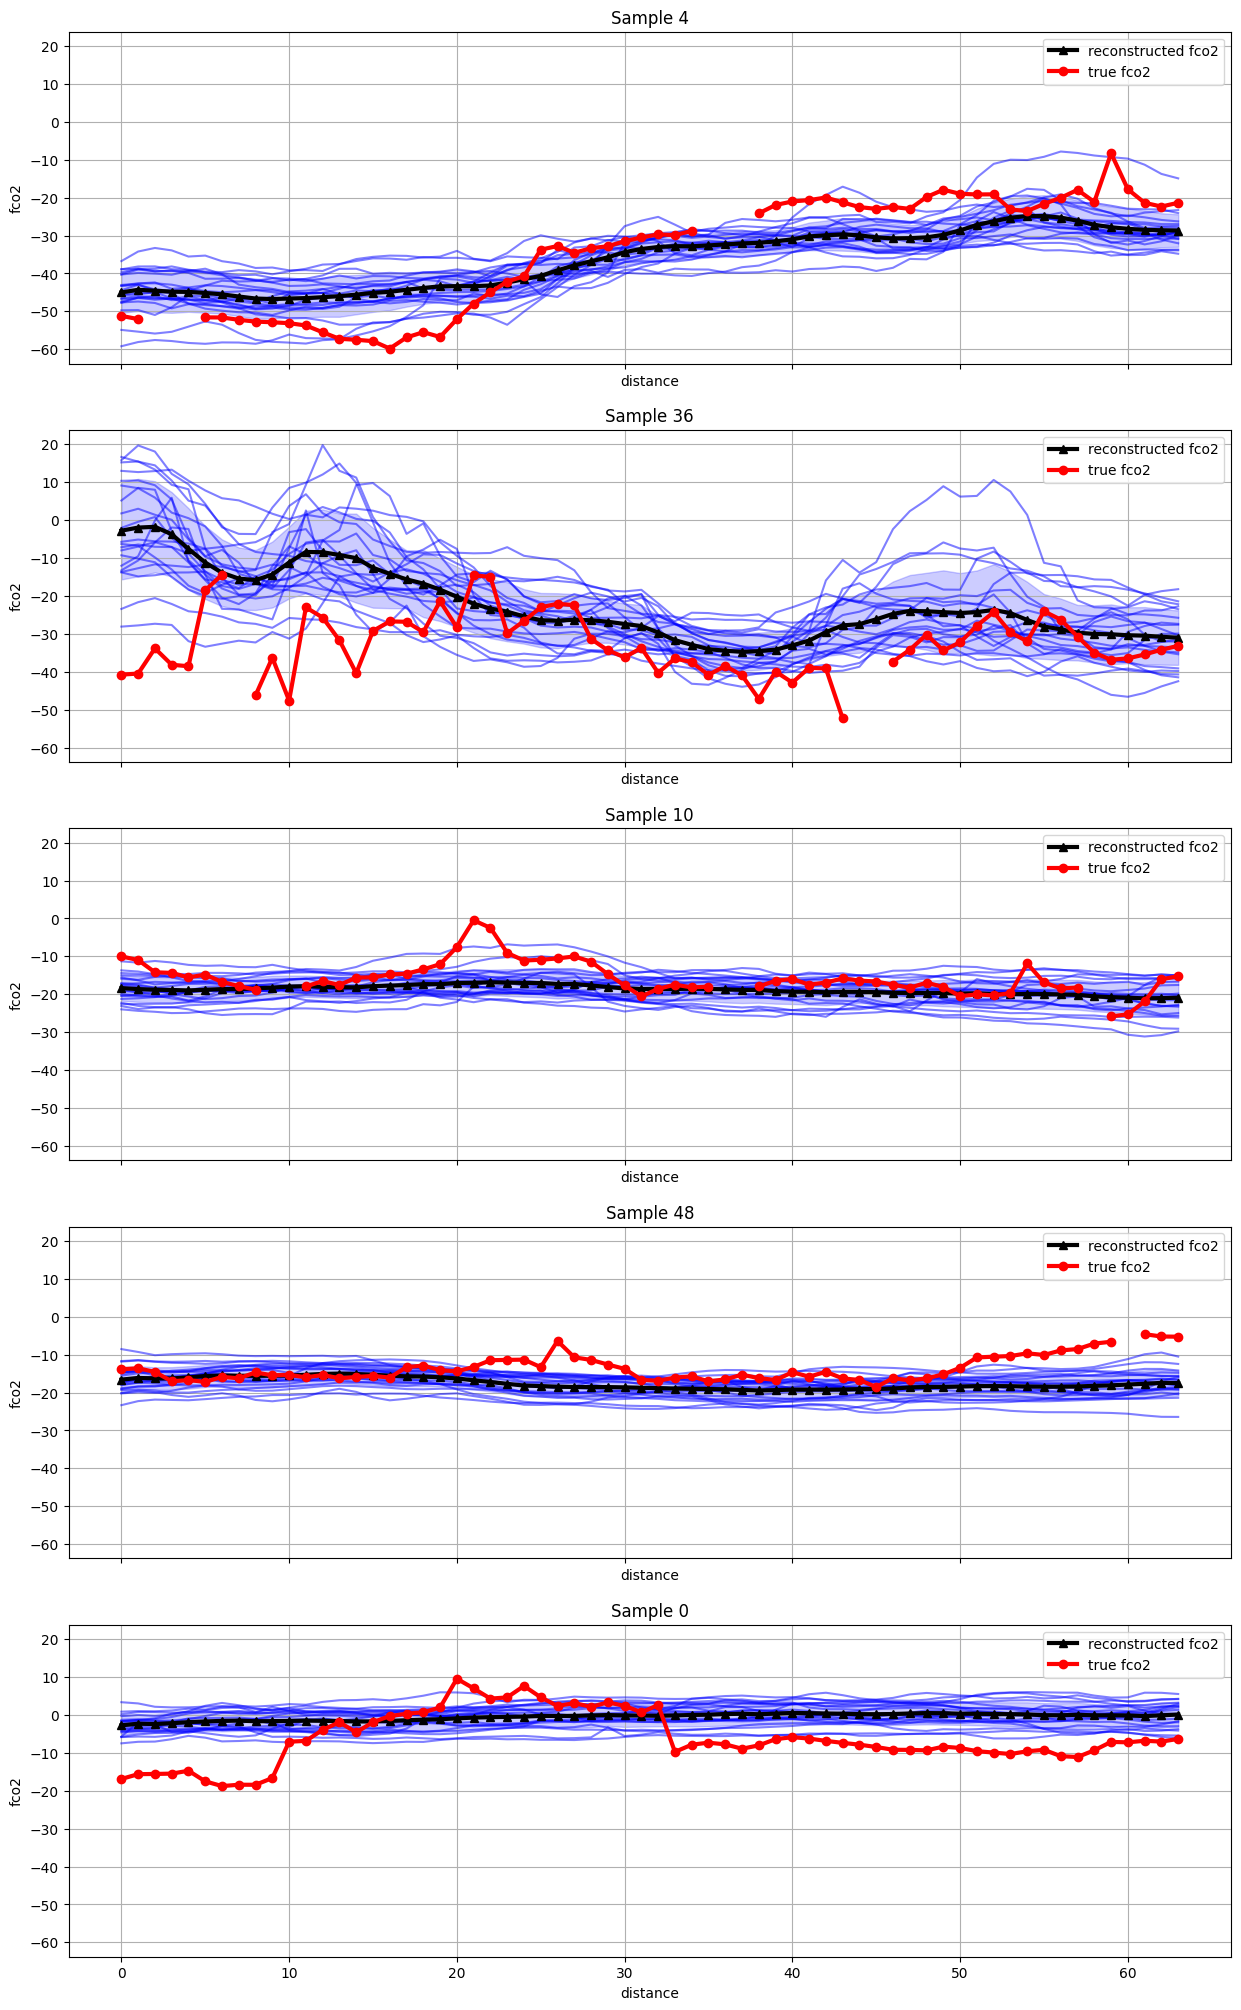

In [28]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, n_samples), 5, replace=False)
fig, axs = plt.subplots(len(ixs), 1, figsize=(15, len(ixs)*5), sharex=True, sharey=True)
for i, ax in zip(ixs, axs):
    samples = train_samples[i, :, :]
    truth = train_ds[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

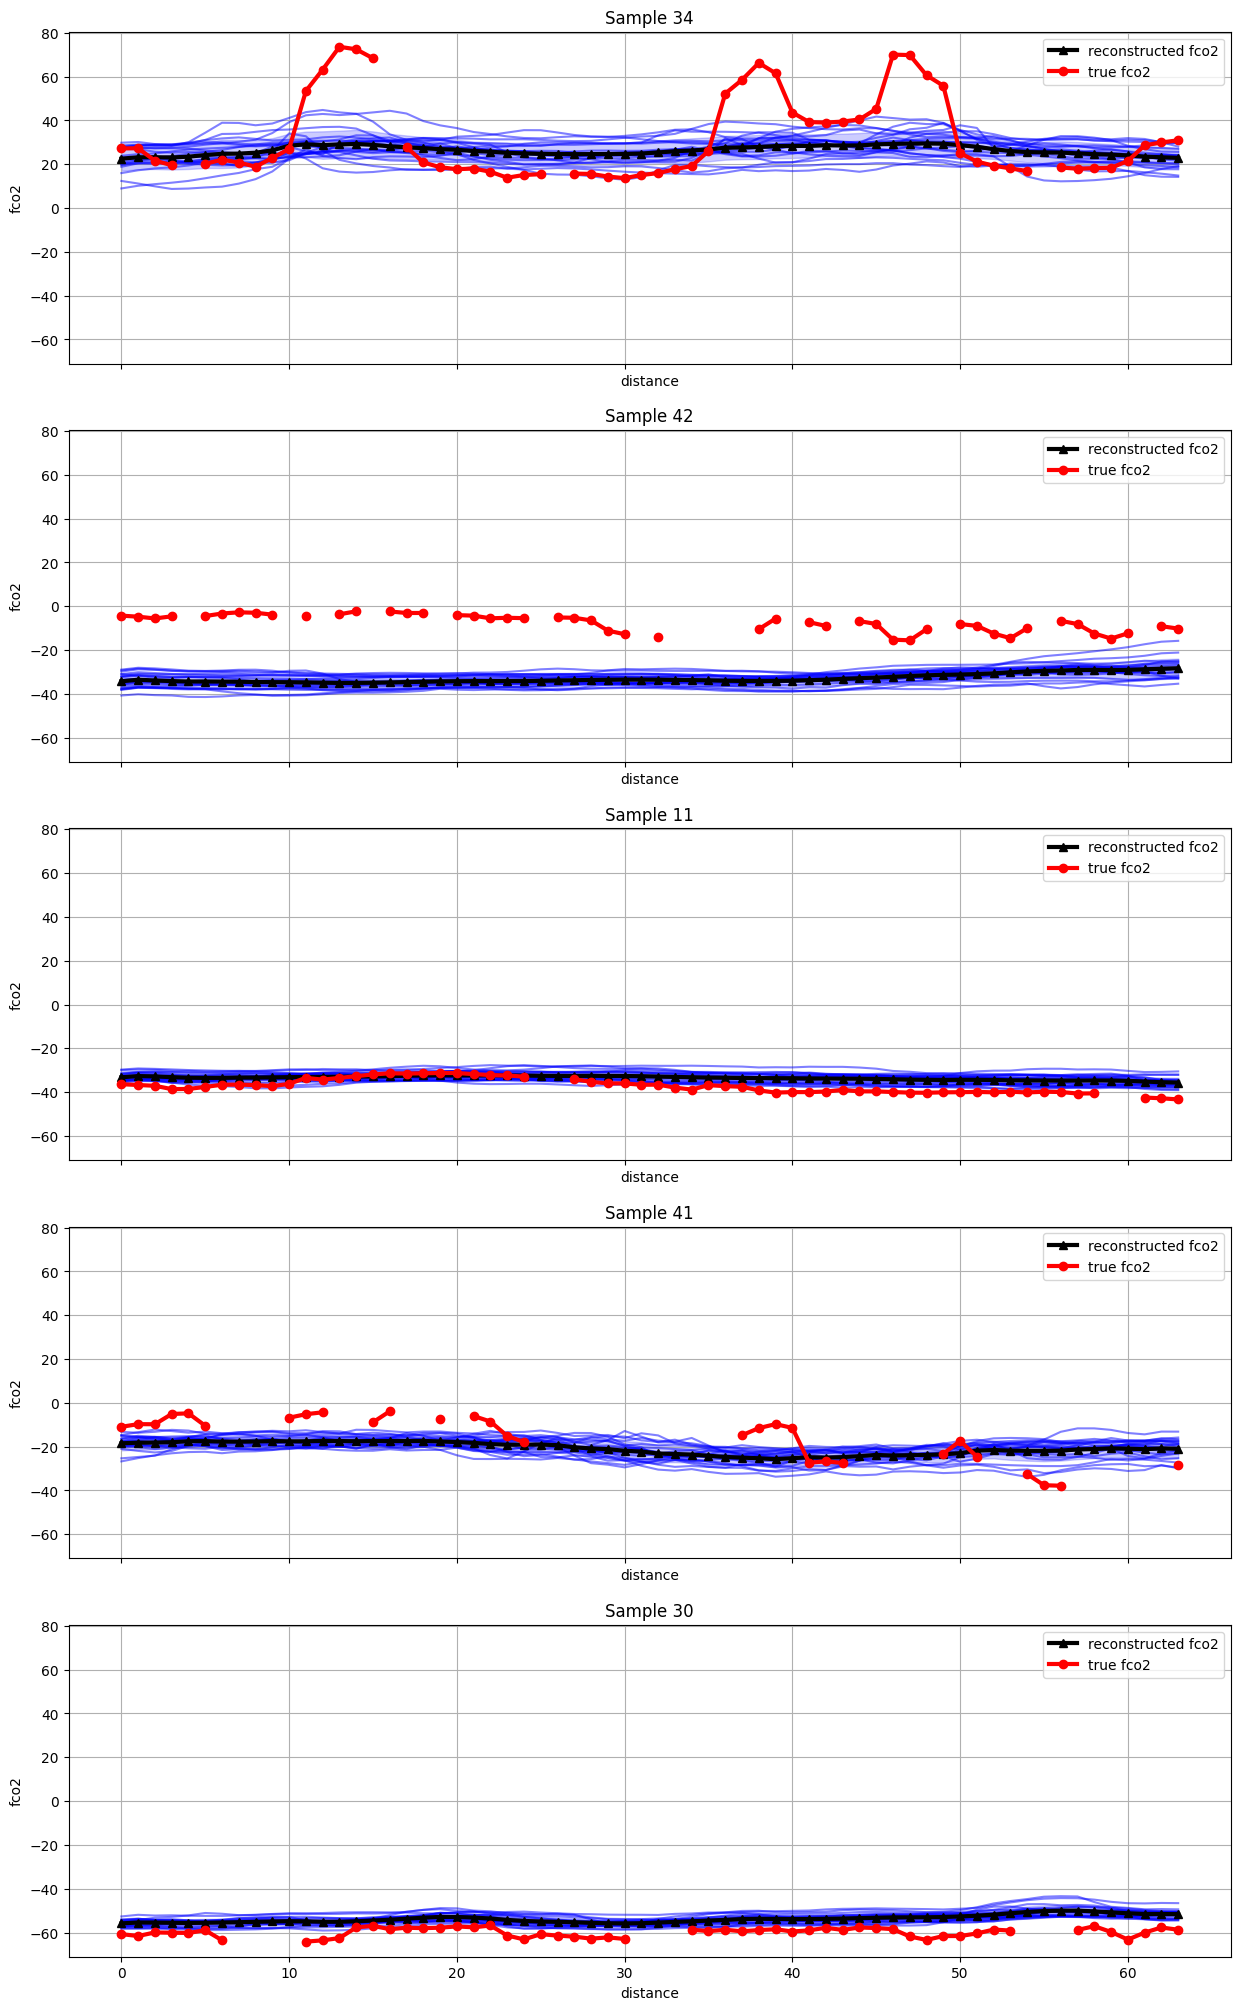

In [30]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, 50), 5, replace=False)
fig, axs = plt.subplots(len(ixs), 1, figsize=(15, len(ixs)*5), sharex=True, sharey=True)
for i, ax in zip(ixs, axs):
    samples = val_samples[i, :, :]
    truth = val_ds[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

# analyse baseline model

In [53]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], index=['segment', 'bin'], bound=True)

2025-05-03 13:33:16,885 - INFO - salinity stacking
2025-05-03 13:33:17,219 - INFO - adding positional and temporal encodings
2025-05-03 13:33:21,817 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 13:33:22,074 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 13:33:23,702 - INFO - salinity stacking
2025-05-03 13:33:23,848 - INFO - adding positional and temporal encodings
2025-05-03 13:33:24,434 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 13:33:24,558 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 13:33:24,724 - INFO - salinity stacking
2025-05-03 13:33:24,769 - INFO - adding positional and temporal encodings
2025-05-03 13:33:25,000 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 13:33:25,065 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


In [74]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/baseline/naivepos/'
model_path = 'e_70.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Baseline model loaded")

Baseline model loaded


In [56]:
train_losses = losses['train_losses']
val_losses = losses['val_losses']
# print epoch with minimum loss
print("Epoch with minimum training loss: ", np.argmin(train_losses))
print("Minimum training loss: ", np.min(train_losses))

print("Epoch with minimum validation loss: ", np.argmin(val_losses))
print("Minimum validation loss: ", np.min(val_losses))

Epoch with minimum training loss:  99
Minimum training loss:  0.09370462538964015
Epoch with minimum validation loss:  37
Minimum validation loss:  0.2166856419168074


In [58]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
train_ds, val_ds = prepare_segment_ds([train_df, val_df], predictors, with_mask=True)
train_stats = get_stats(train_ds)
np.random.shuffle(val_ds)
train_ds_norm, val_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy()], train_stats, params['mode'], ignore=[7, 8, 9, 10, 11, 12])
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-05-03 13:34:10,015 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  209343
yX shape: (12, 209343, 64)


2025-05-03 13:34:14,577 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  22441
yX shape: (12, 22441, 64)


2025-05-03 13:34:19,487 - INFO - Means: [np.float64(-31.85515019522005), np.float64(291.49492360826207), np.float64(32.558164963890555), np.float64(0.6836796394383253), np.float64(0.05670852774367465), np.float64(37.11385439700527), np.float64(392.4558850338762), np.float64(0.6470912102728014), np.float64(0.02198655885396615), np.float64(0.2753931007614051), np.float64(-0.16399171357166006), np.float64(0.07971597452035714), np.float64(0.8040780411812194)]
2025-05-03 13:34:19,487 - INFO - Stds: [np.float64(55.44230006579691), np.float64(9.417746927771578), np.float64(7.516368452649472), np.float64(1.8752586802383828), np.float64(0.10902147425141874), np.float64(56.17053871096368), np.float64(13.507788179586058), np.float64(0.2978493992686017), np.float64(0.7014807879549392), np.float64(0.5414473433774956), np.float64(0.4989884100091686), np.float64(0.5905557233560285), np.float64(0.3969087361993846)]
2025-05-03 13:34:19,487 - INFO - Mins: [np.float64(-391.4479064941406), np.float64(271.

train_ds shape:  (209343, 13, 64)
val_ds shape:  (22441, 13, 64)


In [59]:
assert np.allclose(train_stats['maxs'], params['train_maxs'])
assert np.allclose(train_stats['mins'], params['train_mins'])
assert np.allclose(train_stats['means'], params['train_means'])
assert np.allclose(train_stats['stds'], params['train_stds'])

AssertionError: 

In [60]:
n_samples = val_ds_norm.shape[0]

In [ ]:
def wrap_and_eval_mean_estimator(s, model, n_samples=50):
    from torch.utils.data import DataLoader, TensorDataset
    from fco2models.umeanest import predict_mean_eval
    s_context = s[:n_samples]
    print("context_ds shape: ", s_context.shape)
    s_context_ds = TensorDataset(torch.from_numpy(s_context).float())
    
    s_context_loader = DataLoader(s_context_ds, batch_size=256, shuffle=False)
    
    with torch.no_grad():
        # denoise the samples
        print("Estimating mean samples")
        losses, s_means_norm = predict_mean_eval(model, s_context_loader)
    return s_means_norm, losses
    

In [75]:
val_means_norm, val_losses = wrap_and_eval_mean_estimator(val_ds_norm, model, n_samples=n_samples)

context_ds shape:  (22441, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 176/176 [00:09<00:00, 19.30it/s, Loss=nan]


In [76]:
train_means_norm, train_losses = wrap_and_eval_mean_estimator(train_ds_norm, model, n_samples=n_samples)

context_ds shape:  (22441, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting:   1%|          | 2/176 [00:00<00:09, 18.67it/s, Loss=nan]

Predicting: 100%|██████████| 176/176 [00:08<00:00, 19.90it/s, Loss=nan]


In [65]:
val_means_norm.shape

(22441, 1, 64)

In [77]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_means = rescale(
    val_means_norm.copy(), stats, params['mode']
    ).reshape(val_means_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_error_dict = get_error_stats(
    val_means, 
    val_ds[:n_samples, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 35.8991
MAE: 23.6440
R2: 0.5583
Bias: -1.2655 ± 30.5252
Mean correlation: 0.1880 ± 0.4642


In [78]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_means = rescale(
    train_means_norm.copy(), stats, params['mode']
    ).reshape(train_means_norm.shape)
train_error_dict = get_error_stats(
    train_means, 
    train_ds[:n_samples, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 28.6868
MAE: 19.7831
R2: 0.6355
Bias: -3.5066 ± 24.7657
Mean correlation: 0.2183 ± 0.4593


In [79]:
import matplotlib.pyplot as plt
def plot_preds(preds, ds, ixs, random_preds=None):
    fig, axs = plt.subplots(len(ixs), 1, sharex=True, sharey=True, figsize=(20,len(ixs) * 5))
    for (i, ix) in enumerate(ixs):
        axs[i].plot(preds[ix, 0, :].T, '^-', label='prediction', color='blue', alpha=0.5, linewidth=2)
        axs[i].plot(ds[ix, 0, :].T, 'o-', label='original', color='red', alpha=1, linewidth=2)
        if random_preds is not None:
            axs[i].plot(random_preds[ix, 0, :].T, 'o-', label='random prediction', color='green', alpha=0.5)
        axs[i].set_title(f'Prediction vs original {ix}')
        axs[i].set_xlabel('bins')
        axs[i].set_ylabel('fCO2')

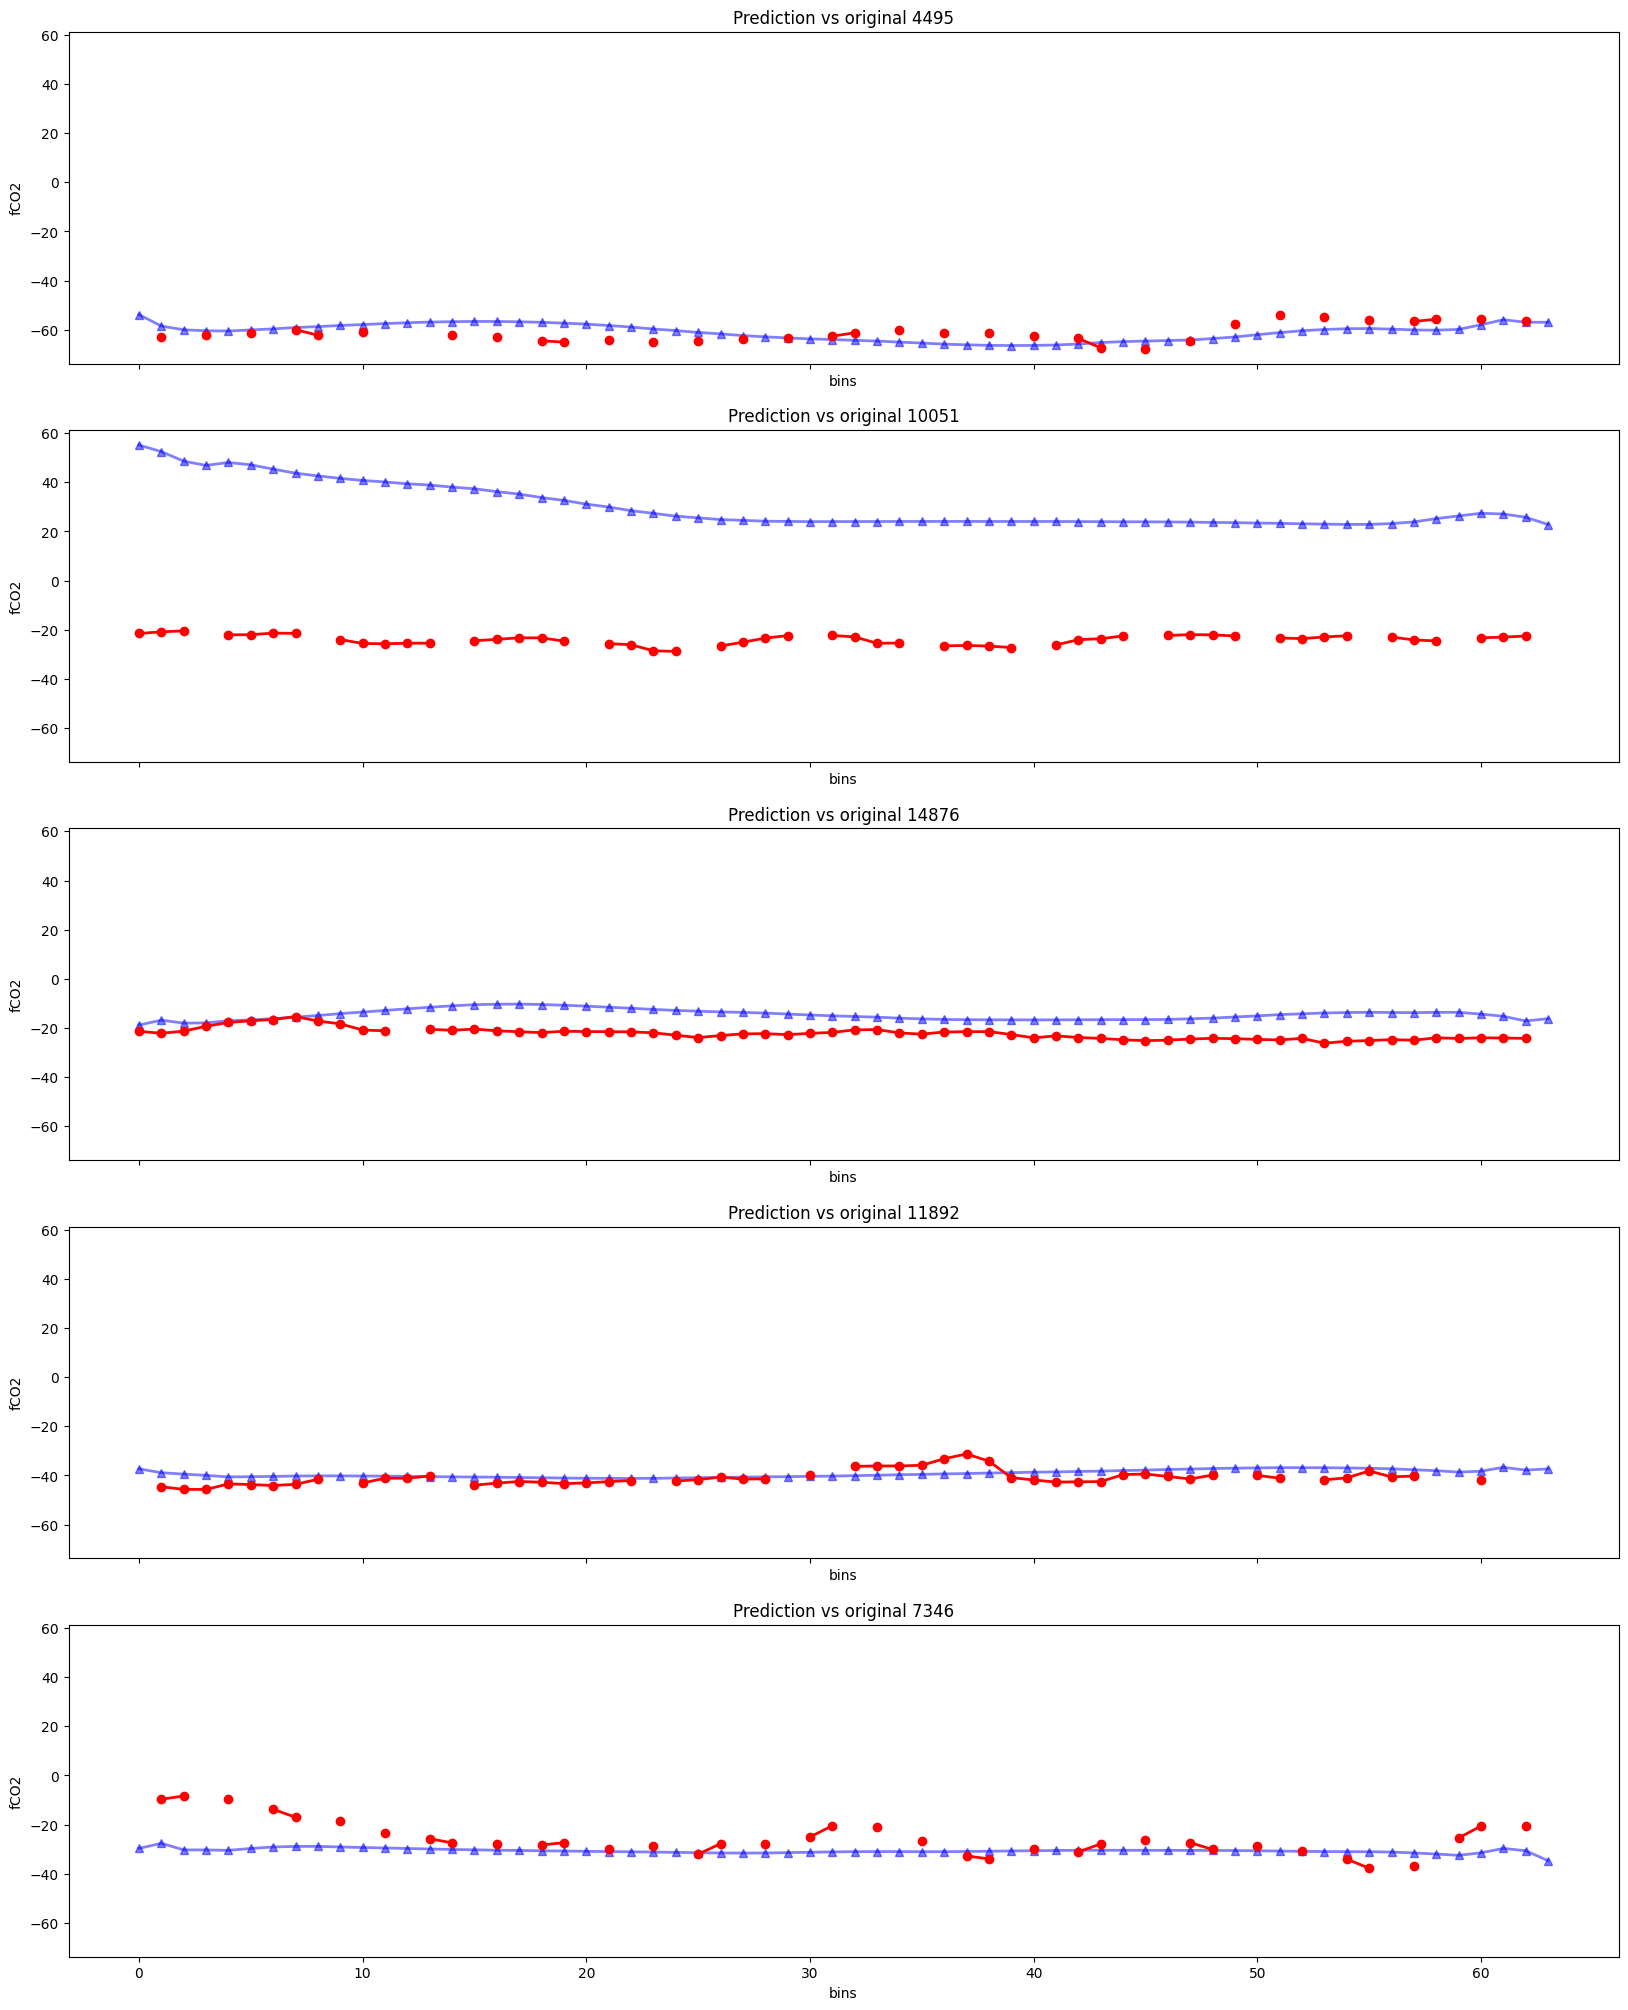

In [84]:
plot_preds(train_means, train_ds[:n_samples], np.random.choice(np.arange(n_samples), size=5, replace=False))

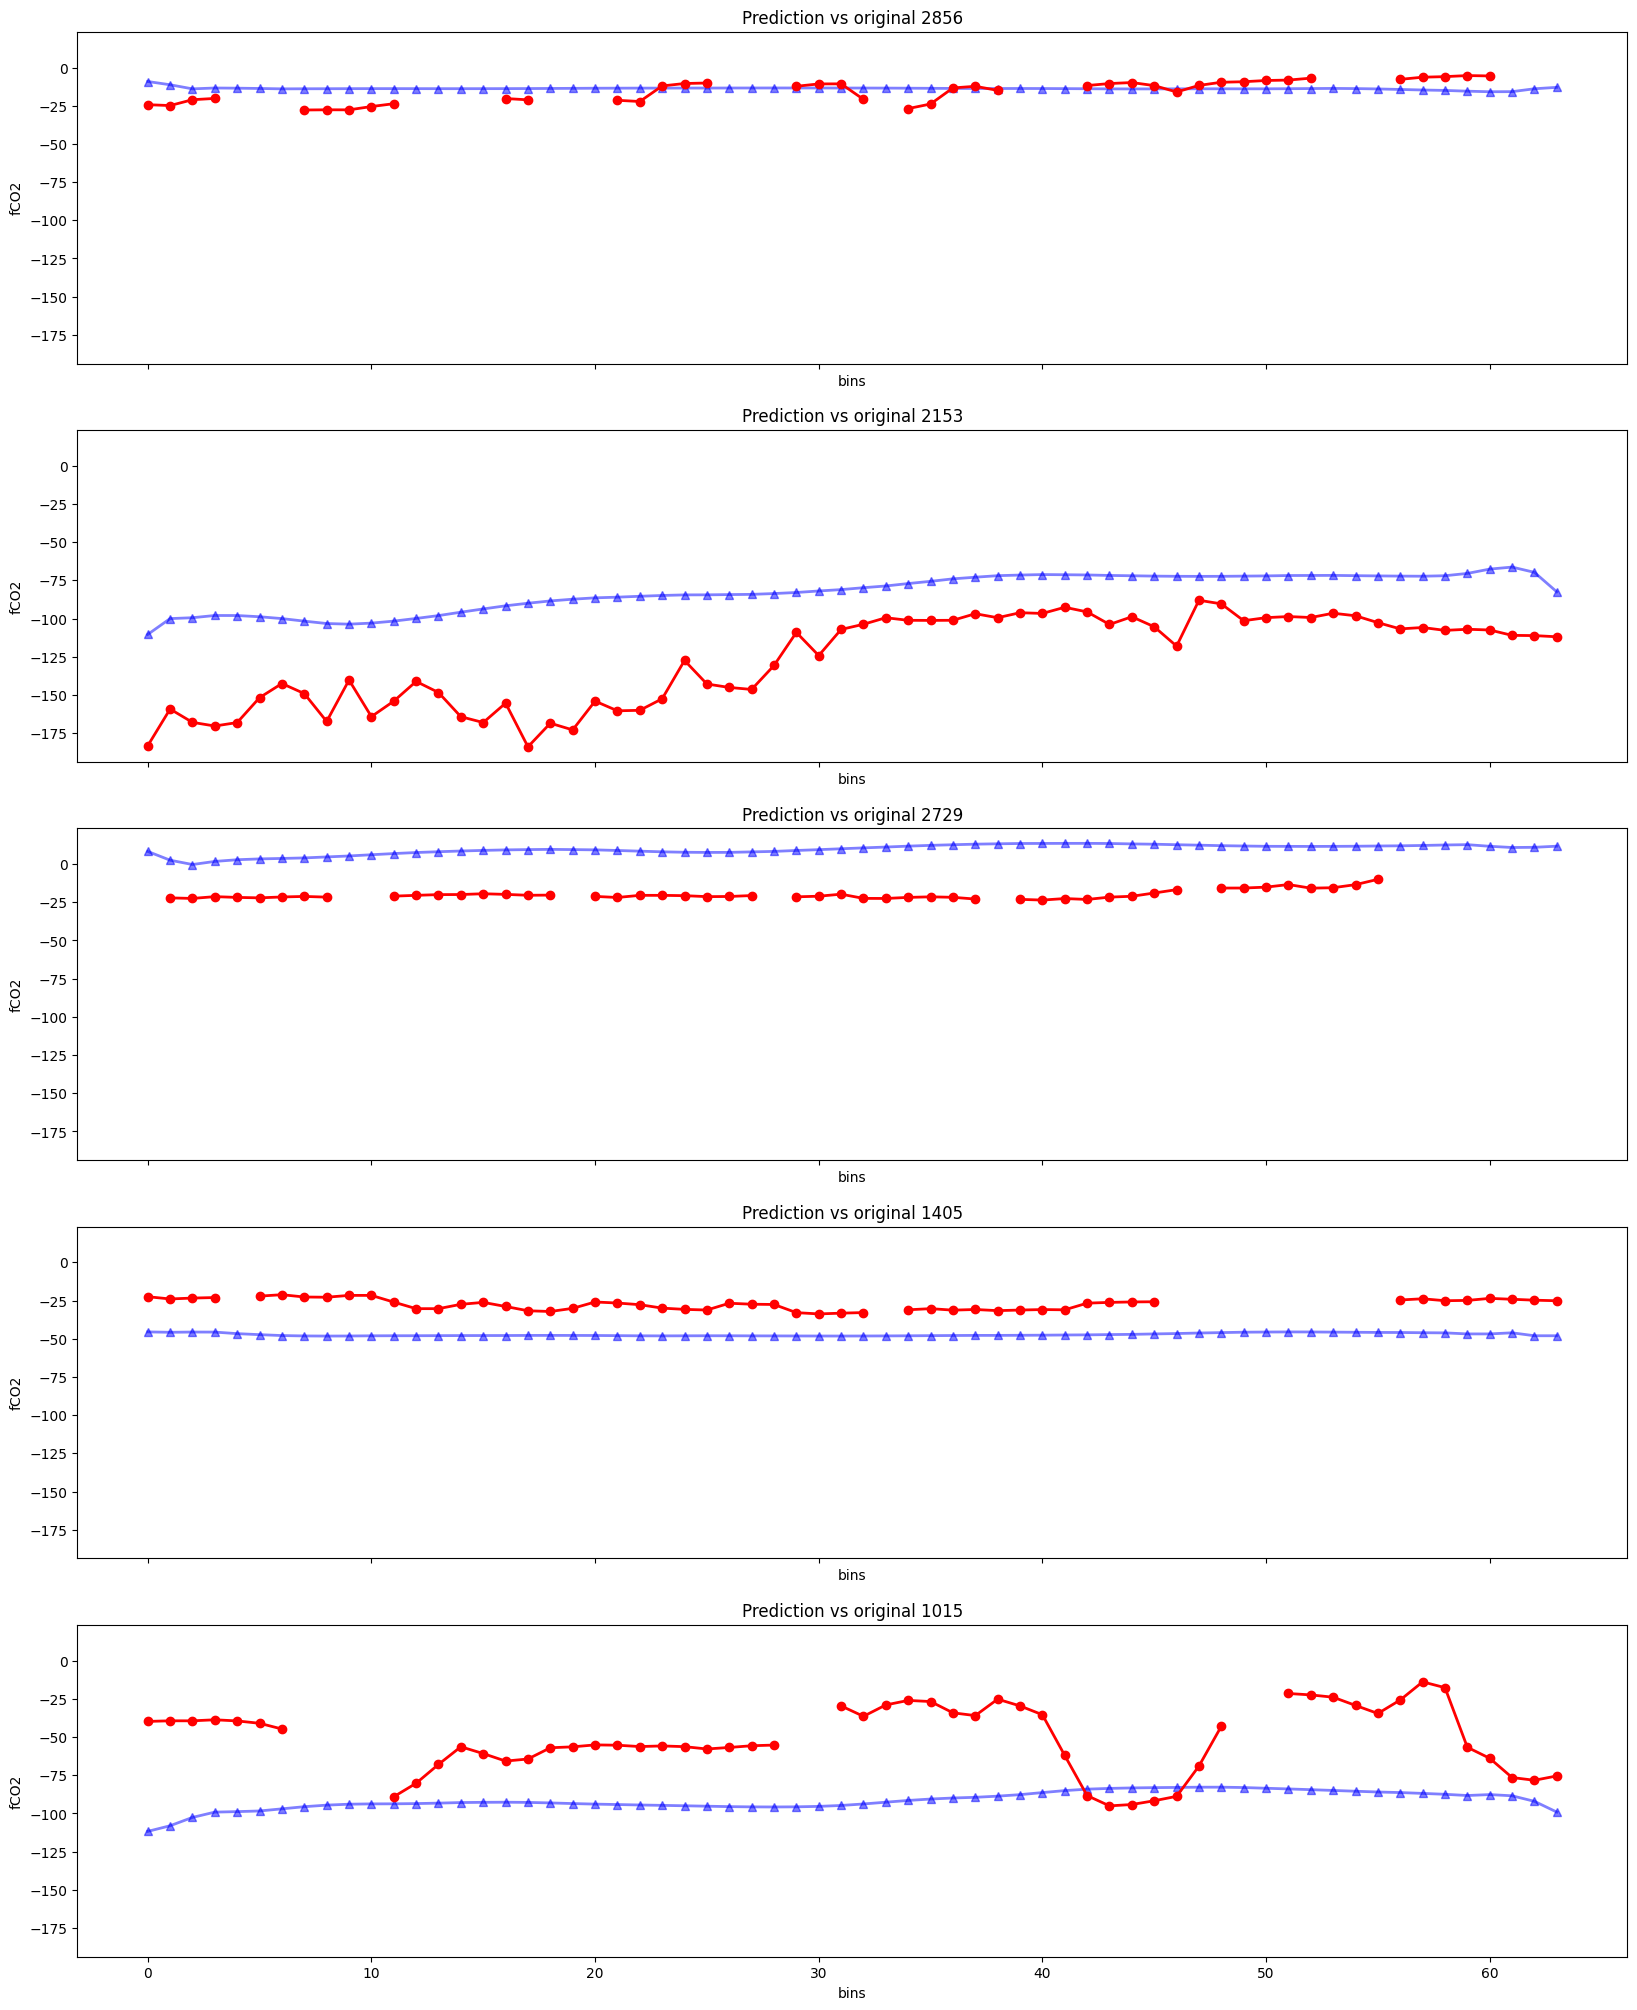

In [83]:
plot_preds(val_means, val_ds[:3000], np.random.choice(np.arange(3000), size=5, replace=False))